# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/recon_max_sparse_top_{N}_v2.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/recon_max_sparse_ablated_top_{N}_v2.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

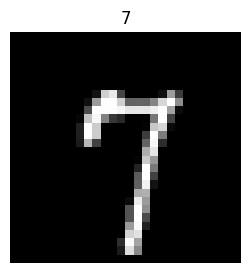

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [13]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [14]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [17]:
loss_factors = np.arange(0.005, 0.012 + 0.001, 0.001)
print(len(loss_factors))

8


In [18]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

##################################################
Loss factor: 0.005




Epoch 1/20
  Train Loss: 1.0523
  SAE Train Loss (hidden one): 8.8844
  SAE Train Loss (hidden two): 1.1681
  Val Loss: 0.5447 | Val Acc: 84.56%
  Saved model with Val Acc: 84.56%


Epoch 2/20
  Train Loss: 0.4613
  SAE Train Loss (hidden one): 0.6206
  SAE Train Loss (hidden two): 0.1092
  Val Loss: 0.4477 | Val Acc: 86.79%
  Saved model with Val Acc: 86.79%


Epoch 3/20
  Train Loss: 0.3832
  SAE Train Loss (hidden one): 0.6165
  SAE Train Loss (hidden two): 0.0932
  Val Loss: 0.3905 | Val Acc: 88.70%
  Saved model with Val Acc: 88.70%


Epoch 4/20
  Train Loss: 0.3571
  SAE Train Loss (hidden one): 0.6342
  SAE Train Loss (hidden two): 0.0816
  Val Loss: 0.3518 | Val Acc: 89.66%
  Saved model with Val Acc: 89.66%


Epoch 5/20
  Train Loss: 0.3355
  SAE Train Loss (hidden one): 0.7066
  SAE Train Loss (hidden two): 0.0771
  Val Loss: 0.3603 | Val Acc: 88.96%


Epoch 6/20
  Train Loss: 0.3227
  SAE Train Loss (hidden one): 0.7061
  SAE Train Loss (hidden two): 0.0753
  Val Loss: 0.3239 | Val Acc: 90.79%
  Saved model with Val Acc: 90.79%


Epoch 7/20
  Train Loss: 0.3133
  SAE Train Loss (hidden one): 0.7820
  SAE Train Loss (hidden two): 0.0703
  Val Loss: 0.3302 | Val Acc: 90.34%


Epoch 8/20
  Train Loss: 0.3084
  SAE Train Loss (hidden one): 0.8143
  SAE Train Loss (hidden two): 0.0692
  Val Loss: 0.3205 | Val Acc: 90.69%


Epoch 9/20
  Train Loss: 0.2931
  SAE Train Loss (hidden one): 0.8272
  SAE Train Loss (hidden two): 0.0681
  Val Loss: 0.3237 | Val Acc: 90.80%
  Saved model with Val Acc: 90.80%


Epoch 10/20
  Train Loss: 0.2901
  SAE Train Loss (hidden one): 0.7210
  SAE Train Loss (hidden two): 0.0661
  Val Loss: 0.3328 | Val Acc: 90.34%


Epoch 11/20
  Train Loss: 0.2826
  SAE Train Loss (hidden one): 0.7582
  SAE Train Loss (hidden two): 0.0641
  Val Loss: 0.3018 | Val Acc: 91.36%
  Saved model with Val Acc: 91.36%


Epoch 12/20
  Train Loss: 0.2797
  SAE Train Loss (hidden one): 0.7531
  SAE Train Loss (hidden two): 0.0634
  Val Loss: 0.2943 | Val Acc: 91.53%
  Saved model with Val Acc: 91.53%


Epoch 13/20
  Train Loss: 0.2728
  SAE Train Loss (hidden one): 0.7200
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.3050 | Val Acc: 91.03%


Epoch 14/20
  Train Loss: 0.2699
  SAE Train Loss (hidden one): 0.8049
  SAE Train Loss (hidden two): 0.0593
  Val Loss: 0.3085 | Val Acc: 91.40%


Epoch 15/20
  Train Loss: 0.2676
  SAE Train Loss (hidden one): 0.8124
  SAE Train Loss (hidden two): 0.0570
  Val Loss: 0.3201 | Val Acc: 90.77%


Epoch 16/20
  Train Loss: 0.2644
  SAE Train Loss (hidden one): 1.1359
  SAE Train Loss (hidden two): 0.0571
  Val Loss: 0.3000 | Val Acc: 91.70%
  Saved model with Val Acc: 91.70%


Epoch 17/20
  Train Loss: 0.2587
  SAE Train Loss (hidden one): 0.9277
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.2918 | Val Acc: 92.21%
  Saved model with Val Acc: 92.21%


Epoch 18/20
  Train Loss: 0.2539
  SAE Train Loss (hidden one): 1.0495
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.2906 | Val Acc: 91.55%


Epoch 19/20
  Train Loss: 0.2483
  SAE Train Loss (hidden one): 0.8905
  SAE Train Loss (hidden two): 0.0539
  Val Loss: 0.3104 | Val Acc: 91.28%


Epoch 20/20
  Train Loss: 0.2442
  SAE Train Loss (hidden one): 0.9196
  SAE Train Loss (hidden two): 0.0500
  Val Loss: 0.2878 | Val Acc: 91.98%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 289.81it/s]


Final Test Accuracy: 91.69%
Average Reconstruction Error (Hidden One): 1.4565
Average Reconstruction Error (Hidden Two): 0.0200
Average Non-Zero Features per Image (Hidden One): 33.82
Average Non-Zero Features per Image (Hidden Two): 33.79


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.32%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.17%

##################################################
Loss factor: 0.006




Epoch 1/20
  Train Loss: 1.0482
  SAE Train Loss (hidden one): 8.5346
  SAE Train Loss (hidden two): 1.1557
  Val Loss: 0.5954 | Val Acc: 84.77%
  Saved model with Val Acc: 84.77%


Epoch 2/20
  Train Loss: 0.5065
  SAE Train Loss (hidden one): 0.4489
  SAE Train Loss (hidden two): 0.0971
  Val Loss: 0.4652 | Val Acc: 86.41%
  Saved model with Val Acc: 86.41%


Epoch 3/20
  Train Loss: 0.4132
  SAE Train Loss (hidden one): 0.4787
  SAE Train Loss (hidden two): 0.0840
  Val Loss: 0.4393 | Val Acc: 87.78%
  Saved model with Val Acc: 87.78%


Epoch 4/20
  Train Loss: 0.3830
  SAE Train Loss (hidden one): 0.4645
  SAE Train Loss (hidden two): 0.0720
  Val Loss: 0.3744 | Val Acc: 88.79%
  Saved model with Val Acc: 88.79%


Epoch 5/20
  Train Loss: 0.3697
  SAE Train Loss (hidden one): 0.4910
  SAE Train Loss (hidden two): 0.0677
  Val Loss: 0.3701 | Val Acc: 89.31%
  Saved model with Val Acc: 89.31%


Epoch 6/20
  Train Loss: 0.3553
  SAE Train Loss (hidden one): 0.4959
  SAE Train Loss (hidden two): 0.0639
  Val Loss: 0.3611 | Val Acc: 89.69%
  Saved model with Val Acc: 89.69%


Epoch 7/20
  Train Loss: 0.3509
  SAE Train Loss (hidden one): 0.5024
  SAE Train Loss (hidden two): 0.0651
  Val Loss: 0.3922 | Val Acc: 88.83%


Epoch 8/20
  Train Loss: 0.3416
  SAE Train Loss (hidden one): 0.5289
  SAE Train Loss (hidden two): 0.0603
  Val Loss: 0.3583 | Val Acc: 89.84%
  Saved model with Val Acc: 89.84%


Epoch 9/20
  Train Loss: 0.3307
  SAE Train Loss (hidden one): 0.5141
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.3731 | Val Acc: 89.17%


Epoch 10/20
  Train Loss: 0.3293
  SAE Train Loss (hidden one): 0.4763
  SAE Train Loss (hidden two): 0.0532
  Val Loss: 0.3725 | Val Acc: 89.35%


Epoch 11/20
  Train Loss: 0.3189
  SAE Train Loss (hidden one): 0.5156
  SAE Train Loss (hidden two): 0.0531
  Val Loss: 0.3383 | Val Acc: 90.44%
  Saved model with Val Acc: 90.44%


Epoch 12/20
  Train Loss: 0.3119
  SAE Train Loss (hidden one): 0.5832
  SAE Train Loss (hidden two): 0.0514
  Val Loss: 0.3331 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 13/20
  Train Loss: 0.3070
  SAE Train Loss (hidden one): 0.5434
  SAE Train Loss (hidden two): 0.0511
  Val Loss: 0.3402 | Val Acc: 90.21%


Epoch 14/20
  Train Loss: 0.3031
  SAE Train Loss (hidden one): 0.4976
  SAE Train Loss (hidden two): 0.0499
  Val Loss: 0.3438 | Val Acc: 90.25%


Epoch 15/20
  Train Loss: 0.2972
  SAE Train Loss (hidden one): 0.5830
  SAE Train Loss (hidden two): 0.0498
  Val Loss: 0.3284 | Val Acc: 90.43%


Epoch 16/20
  Train Loss: 0.2939
  SAE Train Loss (hidden one): 0.5615
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.3213 | Val Acc: 90.54%
  Saved model with Val Acc: 90.54%


Epoch 17/20
  Train Loss: 0.2870
  SAE Train Loss (hidden one): 0.5255
  SAE Train Loss (hidden two): 0.0466
  Val Loss: 0.3171 | Val Acc: 90.87%
  Saved model with Val Acc: 90.87%


Epoch 18/20
  Train Loss: 0.2854
  SAE Train Loss (hidden one): 0.5574
  SAE Train Loss (hidden two): 0.0457
  Val Loss: 0.3295 | Val Acc: 90.76%


Epoch 19/20
  Train Loss: 0.2833
  SAE Train Loss (hidden one): 0.5407
  SAE Train Loss (hidden two): 0.0431
  Val Loss: 0.3425 | Val Acc: 89.86%


Epoch 20/20
  Train Loss: 0.2794
  SAE Train Loss (hidden one): 0.6323
  SAE Train Loss (hidden two): 0.0424
  Val Loss: 0.3242 | Val Acc: 90.73%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 307.70it/s]


Final Test Accuracy: 91.04%
Average Reconstruction Error (Hidden One): 0.2624
Average Reconstruction Error (Hidden Two): 0.0190
Average Non-Zero Features per Image (Hidden One): 32.79
Average Non-Zero Features per Image (Hidden Two): 32.81


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 90.37%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 89.09%

##################################################
Loss factor: 0.007




Epoch 1/20
  Train Loss: 1.0620
  SAE Train Loss (hidden one): 8.5418
  SAE Train Loss (hidden two): 1.1608
  Val Loss: 0.6094 | Val Acc: 83.48%
  Saved model with Val Acc: 83.48%


Epoch 2/20
  Train Loss: 0.5220
  SAE Train Loss (hidden one): 0.5620
  SAE Train Loss (hidden two): 0.1128
  Val Loss: 0.4995 | Val Acc: 85.25%
  Saved model with Val Acc: 85.25%


Epoch 3/20
  Train Loss: 0.4353
  SAE Train Loss (hidden one): 0.6470
  SAE Train Loss (hidden two): 0.1017
  Val Loss: 0.4259 | Val Acc: 87.74%
  Saved model with Val Acc: 87.74%


Epoch 4/20
  Train Loss: 0.3935
  SAE Train Loss (hidden one): 0.5985
  SAE Train Loss (hidden two): 0.0901
  Val Loss: 0.3919 | Val Acc: 88.57%
  Saved model with Val Acc: 88.57%


Epoch 5/20
  Train Loss: 0.3670
  SAE Train Loss (hidden one): 0.6558
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3736 | Val Acc: 89.36%
  Saved model with Val Acc: 89.36%


Epoch 6/20
  Train Loss: 0.3498
  SAE Train Loss (hidden one): 0.6894
  SAE Train Loss (hidden two): 0.0845
  Val Loss: 0.3601 | Val Acc: 89.91%
  Saved model with Val Acc: 89.91%


Epoch 7/20
  Train Loss: 0.3372
  SAE Train Loss (hidden one): 0.6794
  SAE Train Loss (hidden two): 0.0808
  Val Loss: 0.3540 | Val Acc: 90.16%
  Saved model with Val Acc: 90.16%


Epoch 8/20
  Train Loss: 0.3266
  SAE Train Loss (hidden one): 0.6488
  SAE Train Loss (hidden two): 0.0744
  Val Loss: 0.3411 | Val Acc: 90.44%
  Saved model with Val Acc: 90.44%


Epoch 9/20
  Train Loss: 0.3179
  SAE Train Loss (hidden one): 0.6891
  SAE Train Loss (hidden two): 0.0711
  Val Loss: 0.3636 | Val Acc: 89.32%


Epoch 10/20
  Train Loss: 0.3144
  SAE Train Loss (hidden one): 0.5900
  SAE Train Loss (hidden two): 0.0678
  Val Loss: 0.3548 | Val Acc: 89.90%


Epoch 11/20
  Train Loss: 0.3073
  SAE Train Loss (hidden one): 0.7003
  SAE Train Loss (hidden two): 0.0650
  Val Loss: 0.3325 | Val Acc: 90.37%


Epoch 12/20
  Train Loss: 0.3020
  SAE Train Loss (hidden one): 0.6415
  SAE Train Loss (hidden two): 0.0606
  Val Loss: 0.3311 | Val Acc: 90.43%


Epoch 13/20
  Train Loss: 0.2973
  SAE Train Loss (hidden one): 0.6939
  SAE Train Loss (hidden two): 0.0594
  Val Loss: 0.3226 | Val Acc: 90.83%
  Saved model with Val Acc: 90.83%


Epoch 14/20
  Train Loss: 0.2965
  SAE Train Loss (hidden one): 0.6587
  SAE Train Loss (hidden two): 0.0583
  Val Loss: 0.3489 | Val Acc: 90.52%


Epoch 15/20
  Train Loss: 0.2906
  SAE Train Loss (hidden one): 0.7743
  SAE Train Loss (hidden two): 0.0563
  Val Loss: 0.3384 | Val Acc: 90.48%


Epoch 16/20
  Train Loss: 0.2882
  SAE Train Loss (hidden one): 0.6029
  SAE Train Loss (hidden two): 0.0556
  Val Loss: 0.3170 | Val Acc: 90.80%


Epoch 17/20
  Train Loss: 0.2843
  SAE Train Loss (hidden one): 0.6942
  SAE Train Loss (hidden two): 0.0534
  Val Loss: 0.3160 | Val Acc: 90.71%


Epoch 18/20
  Train Loss: 0.2827
  SAE Train Loss (hidden one): 0.6912
  SAE Train Loss (hidden two): 0.0510
  Val Loss: 0.3128 | Val Acc: 91.08%
  Saved model with Val Acc: 91.08%


Epoch 19/20
  Train Loss: 0.2821
  SAE Train Loss (hidden one): 0.6569
  SAE Train Loss (hidden two): 0.0527
  Val Loss: 0.3117 | Val Acc: 90.80%


Epoch 20/20
  Train Loss: 0.2785
  SAE Train Loss (hidden one): 0.6799
  SAE Train Loss (hidden two): 0.0486
  Val Loss: 0.3152 | Val Acc: 91.04%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 281.58it/s]

Final Test Accuracy: 91.43%
Average Reconstruction Error (Hidden One): 0.1823
Average Reconstruction Error (Hidden Two): 0.0157
Average Non-Zero Features per Image (Hidden One): 32.31
Average Non-Zero Features per Image (Hidden Two): 34.93



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.19%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.57%

##################################################
Loss factor: 0.008




Epoch 1/20
  Train Loss: 1.0699
  SAE Train Loss (hidden one): 8.7370
  SAE Train Loss (hidden two): 1.1543
  Val Loss: 0.5723 | Val Acc: 83.21%
  Saved model with Val Acc: 83.21%


Epoch 2/20
  Train Loss: 0.4567
  SAE Train Loss (hidden one): 0.6109
  SAE Train Loss (hidden two): 0.1171
  Val Loss: 0.4697 | Val Acc: 85.95%
  Saved model with Val Acc: 85.95%


Epoch 3/20
  Train Loss: 0.3865
  SAE Train Loss (hidden one): 0.6030
  SAE Train Loss (hidden two): 0.1001
  Val Loss: 0.3976 | Val Acc: 88.62%
  Saved model with Val Acc: 88.62%


Epoch 4/20
  Train Loss: 0.3605
  SAE Train Loss (hidden one): 0.6327
  SAE Train Loss (hidden two): 0.0888
  Val Loss: 0.3623 | Val Acc: 89.57%
  Saved model with Val Acc: 89.57%


Epoch 5/20
  Train Loss: 0.3462
  SAE Train Loss (hidden one): 0.6301
  SAE Train Loss (hidden two): 0.0839
  Val Loss: 0.3644 | Val Acc: 89.11%


Epoch 6/20
  Train Loss: 0.3305
  SAE Train Loss (hidden one): 0.7085
  SAE Train Loss (hidden two): 0.0813
  Val Loss: 0.3502 | Val Acc: 89.97%
  Saved model with Val Acc: 89.97%


Epoch 7/20
  Train Loss: 0.3201
  SAE Train Loss (hidden one): 0.6729
  SAE Train Loss (hidden two): 0.0781
  Val Loss: 0.3382 | Val Acc: 90.14%
  Saved model with Val Acc: 90.14%


Epoch 8/20
  Train Loss: 0.3125
  SAE Train Loss (hidden one): 0.7660
  SAE Train Loss (hidden two): 0.0753
  Val Loss: 0.3247 | Val Acc: 90.60%
  Saved model with Val Acc: 90.60%


Epoch 9/20
  Train Loss: 0.3016
  SAE Train Loss (hidden one): 0.7609
  SAE Train Loss (hidden two): 0.0729
  Val Loss: 0.3345 | Val Acc: 90.08%


Epoch 10/20
  Train Loss: 0.2962
  SAE Train Loss (hidden one): 0.7181
  SAE Train Loss (hidden two): 0.0683
  Val Loss: 0.3336 | Val Acc: 89.89%


Epoch 11/20
  Train Loss: 0.2872
  SAE Train Loss (hidden one): 0.6727
  SAE Train Loss (hidden two): 0.0652
  Val Loss: 0.3182 | Val Acc: 90.61%
  Saved model with Val Acc: 90.61%


Epoch 12/20
  Train Loss: 0.2877
  SAE Train Loss (hidden one): 0.7534
  SAE Train Loss (hidden two): 0.0635
  Val Loss: 0.3092 | Val Acc: 90.81%
  Saved model with Val Acc: 90.81%


Epoch 13/20
  Train Loss: 0.2783
  SAE Train Loss (hidden one): 0.7388
  SAE Train Loss (hidden two): 0.0633
  Val Loss: 0.3043 | Val Acc: 90.96%
  Saved model with Val Acc: 90.96%


Epoch 14/20
  Train Loss: 0.2764
  SAE Train Loss (hidden one): 0.7420
  SAE Train Loss (hidden two): 0.0608
  Val Loss: 0.3145 | Val Acc: 90.89%


Epoch 15/20
  Train Loss: 0.2753
  SAE Train Loss (hidden one): 0.6816
  SAE Train Loss (hidden two): 0.0583
  Val Loss: 0.3188 | Val Acc: 90.84%


Epoch 16/20
  Train Loss: 0.2703
  SAE Train Loss (hidden one): 0.7992
  SAE Train Loss (hidden two): 0.0572
  Val Loss: 0.2875 | Val Acc: 91.51%
  Saved model with Val Acc: 91.51%


Epoch 17/20
  Train Loss: 0.2682
  SAE Train Loss (hidden one): 0.8092
  SAE Train Loss (hidden two): 0.0560
  Val Loss: 0.2922 | Val Acc: 91.30%


Epoch 18/20
  Train Loss: 0.2659
  SAE Train Loss (hidden one): 0.8294
  SAE Train Loss (hidden two): 0.0543
  Val Loss: 0.2881 | Val Acc: 91.71%
  Saved model with Val Acc: 91.71%


Epoch 19/20
  Train Loss: 0.2640
  SAE Train Loss (hidden one): 0.8081
  SAE Train Loss (hidden two): 0.0539
  Val Loss: 0.2827 | Val Acc: 91.48%


Epoch 20/20
  Train Loss: 0.2576
  SAE Train Loss (hidden one): 0.7638
  SAE Train Loss (hidden two): 0.0518
  Val Loss: 0.3137 | Val Acc: 90.78%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 305.38it/s]


Final Test Accuracy: 91.55%
Average Reconstruction Error (Hidden One): 0.9073
Average Reconstruction Error (Hidden Two): 0.0130
Average Non-Zero Features per Image (Hidden One): 34.19
Average Non-Zero Features per Image (Hidden Two): 34.81


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.03%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.90%

##################################################
Loss factor: 0.009000000000000001




Epoch 1/20
  Train Loss: 1.0514
  SAE Train Loss (hidden one): 8.7074
  SAE Train Loss (hidden two): 1.1568
  Val Loss: 0.5460 | Val Acc: 85.29%
  Saved model with Val Acc: 85.29%


Epoch 2/20
  Train Loss: 0.4406
  SAE Train Loss (hidden one): 0.5788
  SAE Train Loss (hidden two): 0.1110
  Val Loss: 0.4119 | Val Acc: 87.95%
  Saved model with Val Acc: 87.95%


Epoch 3/20
  Train Loss: 0.3626
  SAE Train Loss (hidden one): 0.6360
  SAE Train Loss (hidden two): 0.0989
  Val Loss: 0.3802 | Val Acc: 89.30%
  Saved model with Val Acc: 89.30%


Epoch 4/20
  Train Loss: 0.3404
  SAE Train Loss (hidden one): 0.6364
  SAE Train Loss (hidden two): 0.0891
  Val Loss: 0.3541 | Val Acc: 89.71%
  Saved model with Val Acc: 89.71%


Epoch 5/20
  Train Loss: 0.3238
  SAE Train Loss (hidden one): 0.6243
  SAE Train Loss (hidden two): 0.0858
  Val Loss: 0.3257 | Val Acc: 90.52%
  Saved model with Val Acc: 90.52%


Epoch 6/20
  Train Loss: 0.3093
  SAE Train Loss (hidden one): 0.6930
  SAE Train Loss (hidden two): 0.0840
  Val Loss: 0.3259 | Val Acc: 90.60%
  Saved model with Val Acc: 90.60%


Epoch 7/20
  Train Loss: 0.3043
  SAE Train Loss (hidden one): 0.7074
  SAE Train Loss (hidden two): 0.0802
  Val Loss: 0.3299 | Val Acc: 90.69%
  Saved model with Val Acc: 90.69%


Epoch 8/20
  Train Loss: 0.2951
  SAE Train Loss (hidden one): 0.7746
  SAE Train Loss (hidden two): 0.0795
  Val Loss: 0.3147 | Val Acc: 90.60%


Epoch 9/20
  Train Loss: 0.2892
  SAE Train Loss (hidden one): 0.6770
  SAE Train Loss (hidden two): 0.0745
  Val Loss: 0.3595 | Val Acc: 89.36%


Epoch 10/20
  Train Loss: 0.2842
  SAE Train Loss (hidden one): 0.6294
  SAE Train Loss (hidden two): 0.0690
  Val Loss: 0.2967 | Val Acc: 91.40%
  Saved model with Val Acc: 91.40%


Epoch 11/20
  Train Loss: 0.2783
  SAE Train Loss (hidden one): 0.6537
  SAE Train Loss (hidden two): 0.0685
  Val Loss: 0.2957 | Val Acc: 91.52%
  Saved model with Val Acc: 91.52%


Epoch 12/20
  Train Loss: 0.2740
  SAE Train Loss (hidden one): 0.6662
  SAE Train Loss (hidden two): 0.0655
  Val Loss: 0.3013 | Val Acc: 91.11%


Epoch 13/20
  Train Loss: 0.2709
  SAE Train Loss (hidden one): 0.6237
  SAE Train Loss (hidden two): 0.0623
  Val Loss: 0.2922 | Val Acc: 91.69%
  Saved model with Val Acc: 91.69%


Epoch 14/20
  Train Loss: 0.2670
  SAE Train Loss (hidden one): 0.6265
  SAE Train Loss (hidden two): 0.0588
  Val Loss: 0.3194 | Val Acc: 90.67%


Epoch 15/20
  Train Loss: 0.2646
  SAE Train Loss (hidden one): 0.6163
  SAE Train Loss (hidden two): 0.0575
  Val Loss: 0.3149 | Val Acc: 90.88%


Epoch 16/20
  Train Loss: 0.2634
  SAE Train Loss (hidden one): 0.6271
  SAE Train Loss (hidden two): 0.0561
  Val Loss: 0.3005 | Val Acc: 91.35%


Epoch 17/20
  Train Loss: 0.2590
  SAE Train Loss (hidden one): 0.6335
  SAE Train Loss (hidden two): 0.0536
  Val Loss: 0.3053 | Val Acc: 91.30%


Epoch 18/20
  Train Loss: 0.2584
  SAE Train Loss (hidden one): 0.6390
  SAE Train Loss (hidden two): 0.0535
  Val Loss: 0.2974 | Val Acc: 91.78%
  Saved model with Val Acc: 91.78%


Epoch 19/20
  Train Loss: 0.2540
  SAE Train Loss (hidden one): 0.6358
  SAE Train Loss (hidden two): 0.0516
  Val Loss: 0.3107 | Val Acc: 91.09%


Epoch 20/20
  Train Loss: 0.2526
  SAE Train Loss (hidden one): 0.6699
  SAE Train Loss (hidden two): 0.0483
  Val Loss: 0.2945 | Val Acc: 91.58%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 279.68it/s]

Final Test Accuracy: 92.19%
Average Reconstruction Error (Hidden One): 0.1983
Average Reconstruction Error (Hidden Two): 0.0126
Average Non-Zero Features per Image (Hidden One): 33.85
Average Non-Zero Features per Image (Hidden Two): 35.48



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.78%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 91.11%

##################################################
Loss factor: 0.01




Epoch 1/20
  Train Loss: 1.0450
  SAE Train Loss (hidden one): 8.5595
  SAE Train Loss (hidden two): 1.1525
  Val Loss: 0.5815 | Val Acc: 85.01%
  Saved model with Val Acc: 85.01%


Epoch 2/20
  Train Loss: 0.4416
  SAE Train Loss (hidden one): 0.7260
  SAE Train Loss (hidden two): 0.1108
  Val Loss: 0.3874 | Val Acc: 88.61%
  Saved model with Val Acc: 88.61%


Epoch 3/20
  Train Loss: 0.3644
  SAE Train Loss (hidden one): 0.6123
  SAE Train Loss (hidden two): 0.0994
  Val Loss: 0.3861 | Val Acc: 89.18%
  Saved model with Val Acc: 89.18%


Epoch 4/20
  Train Loss: 0.3381
  SAE Train Loss (hidden one): 0.5993
  SAE Train Loss (hidden two): 0.0903
  Val Loss: 0.3705 | Val Acc: 88.85%


Epoch 5/20
  Train Loss: 0.3215
  SAE Train Loss (hidden one): 0.6478
  SAE Train Loss (hidden two): 0.0901
  Val Loss: 0.3330 | Val Acc: 90.27%
  Saved model with Val Acc: 90.27%


Epoch 6/20
  Train Loss: 0.3116
  SAE Train Loss (hidden one): 0.6877
  SAE Train Loss (hidden two): 0.0865
  Val Loss: 0.3171 | Val Acc: 90.66%
  Saved model with Val Acc: 90.66%


Epoch 7/20
  Train Loss: 0.3012
  SAE Train Loss (hidden one): 0.6510
  SAE Train Loss (hidden two): 0.0808
  Val Loss: 0.3273 | Val Acc: 90.53%


Epoch 8/20
  Train Loss: 0.2971
  SAE Train Loss (hidden one): 0.7040
  SAE Train Loss (hidden two): 0.0804
  Val Loss: 0.3048 | Val Acc: 91.19%
  Saved model with Val Acc: 91.19%


Epoch 9/20
  Train Loss: 0.2903
  SAE Train Loss (hidden one): 0.6797
  SAE Train Loss (hidden two): 0.0758
  Val Loss: 0.3356 | Val Acc: 90.19%


Epoch 10/20
  Train Loss: 0.2882
  SAE Train Loss (hidden one): 0.6289
  SAE Train Loss (hidden two): 0.0706
  Val Loss: 0.3085 | Val Acc: 91.10%


Epoch 11/20
  Train Loss: 0.2789
  SAE Train Loss (hidden one): 0.6600
  SAE Train Loss (hidden two): 0.0696
  Val Loss: 0.3129 | Val Acc: 91.03%


Epoch 12/20
  Train Loss: 0.2784
  SAE Train Loss (hidden one): 0.6757
  SAE Train Loss (hidden two): 0.0693
  Val Loss: 0.3005 | Val Acc: 91.26%
  Saved model with Val Acc: 91.26%


Epoch 13/20
  Train Loss: 0.2761
  SAE Train Loss (hidden one): 0.6679
  SAE Train Loss (hidden two): 0.0652
  Val Loss: 0.3088 | Val Acc: 91.19%


Epoch 14/20
  Train Loss: 0.2724
  SAE Train Loss (hidden one): 0.6516
  SAE Train Loss (hidden two): 0.0633
  Val Loss: 0.3241 | Val Acc: 91.05%


Epoch 15/20
  Train Loss: 0.2681
  SAE Train Loss (hidden one): 0.6729
  SAE Train Loss (hidden two): 0.0600
  Val Loss: 0.3079 | Val Acc: 91.21%


Epoch 16/20
  Train Loss: 0.2671
  SAE Train Loss (hidden one): 0.6805
  SAE Train Loss (hidden two): 0.0603
  Val Loss: 0.3133 | Val Acc: 91.12%


Epoch 17/20
  Train Loss: 0.2650
  SAE Train Loss (hidden one): 0.6788
  SAE Train Loss (hidden two): 0.0578
  Val Loss: 0.2926 | Val Acc: 91.70%
  Saved model with Val Acc: 91.70%


Epoch 18/20
  Train Loss: 0.2654
  SAE Train Loss (hidden one): 0.6401
  SAE Train Loss (hidden two): 0.0568
  Val Loss: 0.2927 | Val Acc: 91.81%
  Saved model with Val Acc: 91.81%


Epoch 19/20
  Train Loss: 0.2633
  SAE Train Loss (hidden one): 0.6844
  SAE Train Loss (hidden two): 0.0541
  Val Loss: 0.2967 | Val Acc: 91.40%


Epoch 20/20
  Train Loss: 0.2576
  SAE Train Loss (hidden one): 0.6612
  SAE Train Loss (hidden two): 0.0523
  Val Loss: 0.3098 | Val Acc: 91.18%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 290.90it/s]


Final Test Accuracy: 91.69%
Average Reconstruction Error (Hidden One): 0.8081
Average Reconstruction Error (Hidden Two): 0.0140
Average Non-Zero Features per Image (Hidden One): 33.72
Average Non-Zero Features per Image (Hidden Two): 35.68


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 91.29%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 90.98%

##################################################
Loss factor: 0.011




Epoch 1/20
  Train Loss: 1.0205
  SAE Train Loss (hidden one): 8.7698
  SAE Train Loss (hidden two): 1.1602
  Val Loss: 0.4933 | Val Acc: 85.98%
  Saved model with Val Acc: 85.98%


Epoch 2/20
  Train Loss: 0.4337
  SAE Train Loss (hidden one): 0.4807
  SAE Train Loss (hidden two): 0.0986
  Val Loss: 0.4023 | Val Acc: 88.28%
  Saved model with Val Acc: 88.28%


Epoch 3/20
  Train Loss: 0.3810
  SAE Train Loss (hidden one): 0.5469
  SAE Train Loss (hidden two): 0.0863
  Val Loss: 0.3855 | Val Acc: 88.98%
  Saved model with Val Acc: 88.98%


Epoch 4/20
  Train Loss: 0.3578
  SAE Train Loss (hidden one): 0.5722
  SAE Train Loss (hidden two): 0.0808
  Val Loss: 0.3595 | Val Acc: 89.58%
  Saved model with Val Acc: 89.58%


Epoch 5/20
  Train Loss: 0.3434
  SAE Train Loss (hidden one): 0.5962
  SAE Train Loss (hidden two): 0.0760
  Val Loss: 0.3460 | Val Acc: 89.83%
  Saved model with Val Acc: 89.83%


Epoch 6/20
  Train Loss: 0.3253
  SAE Train Loss (hidden one): 0.6708
  SAE Train Loss (hidden two): 0.0747
  Val Loss: 0.3355 | Val Acc: 90.37%
  Saved model with Val Acc: 90.37%


Epoch 7/20
  Train Loss: 0.3144
  SAE Train Loss (hidden one): 0.6782
  SAE Train Loss (hidden two): 0.0714
  Val Loss: 0.3181 | Val Acc: 90.90%
  Saved model with Val Acc: 90.90%


Epoch 8/20
  Train Loss: 0.3041
  SAE Train Loss (hidden one): 0.7288
  SAE Train Loss (hidden two): 0.0703
  Val Loss: 0.3079 | Val Acc: 91.21%
  Saved model with Val Acc: 91.21%


Epoch 9/20
  Train Loss: 0.2949
  SAE Train Loss (hidden one): 0.7624
  SAE Train Loss (hidden two): 0.0680
  Val Loss: 0.3249 | Val Acc: 90.65%


Epoch 10/20
  Train Loss: 0.2923
  SAE Train Loss (hidden one): 0.6519
  SAE Train Loss (hidden two): 0.0636
  Val Loss: 0.3165 | Val Acc: 91.08%


Epoch 11/20
  Train Loss: 0.2851
  SAE Train Loss (hidden one): 0.7062
  SAE Train Loss (hidden two): 0.0621
  Val Loss: 0.2992 | Val Acc: 91.27%
  Saved model with Val Acc: 91.27%


Epoch 12/20
  Train Loss: 0.2833
  SAE Train Loss (hidden one): 0.7139
  SAE Train Loss (hidden two): 0.0581
  Val Loss: 0.3047 | Val Acc: 91.56%
  Saved model with Val Acc: 91.56%


Epoch 13/20
  Train Loss: 0.2781
  SAE Train Loss (hidden one): 0.7330
  SAE Train Loss (hidden two): 0.0577
  Val Loss: 0.3003 | Val Acc: 91.42%


Epoch 14/20
  Train Loss: 0.2737
  SAE Train Loss (hidden one): 0.8549
  SAE Train Loss (hidden two): 0.0580
  Val Loss: 0.2994 | Val Acc: 91.42%


Epoch 15/20
  Train Loss: 0.2725
  SAE Train Loss (hidden one): 0.6004
  SAE Train Loss (hidden two): 0.0540
  Val Loss: 0.2989 | Val Acc: 91.40%


Epoch 16/20
  Train Loss: 0.2687
  SAE Train Loss (hidden one): 0.7203
  SAE Train Loss (hidden two): 0.0521
  Val Loss: 0.2989 | Val Acc: 91.51%


Epoch 17/20
  Train Loss: 0.2653
  SAE Train Loss (hidden one): 0.7919
  SAE Train Loss (hidden two): 0.0497
  Val Loss: 0.2897 | Val Acc: 91.87%
  Saved model with Val Acc: 91.87%


Epoch 18/20
  Train Loss: 0.2637
  SAE Train Loss (hidden one): 0.6167
  SAE Train Loss (hidden two): 0.0490
  Val Loss: 0.2910 | Val Acc: 91.84%


Epoch 19/20
  Train Loss: 0.2629
  SAE Train Loss (hidden one): 0.7162
  SAE Train Loss (hidden two): 0.0476
  Val Loss: 0.2868 | Val Acc: 91.76%


Epoch 20/20
  Train Loss: 0.2613
  SAE Train Loss (hidden one): 0.9580
  SAE Train Loss (hidden two): 0.0474
  Val Loss: 0.2962 | Val Acc: 91.77%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 285.63it/s]

Final Test Accuracy: 92.20%
Average Reconstruction Error (Hidden One): 0.3917
Average Reconstruction Error (Hidden Two): 0.0147
Average Non-Zero Features per Image (Hidden One): 33.74
Average Non-Zero Features per Image (Hidden Two): 34.36



/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 89.94%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 87.76%

##################################################
Loss factor: 0.012




Epoch 1/20
  Train Loss: 1.0314
  SAE Train Loss (hidden one): 8.8752
  SAE Train Loss (hidden two): 1.1762
  Val Loss: 0.5279 | Val Acc: 85.01%
  Saved model with Val Acc: 85.01%


Epoch 2/20
  Train Loss: 0.4649
  SAE Train Loss (hidden one): 0.4909
  SAE Train Loss (hidden two): 0.0956
  Val Loss: 0.4283 | Val Acc: 88.03%
  Saved model with Val Acc: 88.03%


Epoch 3/20
  Train Loss: 0.3740
  SAE Train Loss (hidden one): 0.5290
  SAE Train Loss (hidden two): 0.0878
  Val Loss: 0.3793 | Val Acc: 89.05%
  Saved model with Val Acc: 89.05%


Epoch 4/20
  Train Loss: 0.3246
  SAE Train Loss (hidden one): 0.5470
  SAE Train Loss (hidden two): 0.0801
  Val Loss: 0.3162 | Val Acc: 90.77%
  Saved model with Val Acc: 90.77%


Epoch 5/20
  Train Loss: 0.3063
  SAE Train Loss (hidden one): 0.5514
  SAE Train Loss (hidden two): 0.0720
  Val Loss: 0.3044 | Val Acc: 91.07%
  Saved model with Val Acc: 91.07%


Epoch 6/20
  Train Loss: 0.2902
  SAE Train Loss (hidden one): 0.5657
  SAE Train Loss (hidden two): 0.0687
  Val Loss: 0.3238 | Val Acc: 91.02%


Epoch 7/20
  Train Loss: 0.2815
  SAE Train Loss (hidden one): 0.5858
  SAE Train Loss (hidden two): 0.0684
  Val Loss: 0.2835 | Val Acc: 91.74%
  Saved model with Val Acc: 91.74%


Epoch 8/20
  Train Loss: 0.2751
  SAE Train Loss (hidden one): 0.6217
  SAE Train Loss (hidden two): 0.0648
  Val Loss: 0.2844 | Val Acc: 91.86%
  Saved model with Val Acc: 91.86%


Epoch 9/20
  Train Loss: 0.2696
  SAE Train Loss (hidden one): 0.6297
  SAE Train Loss (hidden two): 0.0614
  Val Loss: 0.2951 | Val Acc: 91.52%


Epoch 10/20
  Train Loss: 0.2660
  SAE Train Loss (hidden one): 0.5631
  SAE Train Loss (hidden two): 0.0577
  Val Loss: 0.2806 | Val Acc: 91.95%
  Saved model with Val Acc: 91.95%


Epoch 11/20
  Train Loss: 0.2595
  SAE Train Loss (hidden one): 0.6471
  SAE Train Loss (hidden two): 0.0576
  Val Loss: 0.2853 | Val Acc: 91.74%


Epoch 12/20
  Train Loss: 0.2590
  SAE Train Loss (hidden one): 0.6149
  SAE Train Loss (hidden two): 0.0548
  Val Loss: 0.2735 | Val Acc: 92.09%
  Saved model with Val Acc: 92.09%


Epoch 13/20
  Train Loss: 0.2535
  SAE Train Loss (hidden one): 0.6507
  SAE Train Loss (hidden two): 0.0535
  Val Loss: 0.2841 | Val Acc: 91.61%


Epoch 14/20
  Train Loss: 0.2527
  SAE Train Loss (hidden one): 0.6329
  SAE Train Loss (hidden two): 0.0502
  Val Loss: 0.2771 | Val Acc: 91.98%


Epoch 15/20
  Train Loss: 0.2534
  SAE Train Loss (hidden one): 0.6215
  SAE Train Loss (hidden two): 0.0518
  Val Loss: 0.2822 | Val Acc: 91.80%


Epoch 16/20
  Train Loss: 0.2506
  SAE Train Loss (hidden one): 0.6394
  SAE Train Loss (hidden two): 0.0488
  Val Loss: 0.2747 | Val Acc: 92.10%
  Saved model with Val Acc: 92.10%


Epoch 17/20
  Train Loss: 0.2455
  SAE Train Loss (hidden one): 0.6189
  SAE Train Loss (hidden two): 0.0463
  Val Loss: 0.2716 | Val Acc: 92.20%
  Saved model with Val Acc: 92.20%


Epoch 18/20
  Train Loss: 0.2457
  SAE Train Loss (hidden one): 0.6253
  SAE Train Loss (hidden two): 0.0475
  Val Loss: 0.2767 | Val Acc: 92.20%


Epoch 19/20
  Train Loss: 0.2442
  SAE Train Loss (hidden one): 0.6307
  SAE Train Loss (hidden two): 0.0447
  Val Loss: 0.3070 | Val Acc: 90.85%


Epoch 20/20
  Train Loss: 0.2414
  SAE Train Loss (hidden one): 0.5840
  SAE Train Loss (hidden two): 0.0438
  Val Loss: 0.2827 | Val Acc: 92.00%


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 285.95it/s]


Final Test Accuracy: 92.16%
Average Reconstruction Error (Hidden One): 0.5253
Average Reconstruction Error (Hidden Two): 0.0160
Average Non-Zero Features per Image (Hidden One): 33.71
Average Non-Zero Features per Image (Hidden Two): 33.55


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden One): 92.32%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Linear Probe Accuracy (Hidden Two): 86.75%



In [ ]:
loss_data_dict.keys()

In [19]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

0.011
92.2
0.8994
0.8776


In [ ]:
import pickle

file_path = f"./loss_data_dict_0.011_to_0.051.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)